<a href="https://colab.research.google.com/github/aakashnand-kaggle/blue_book_for_bulldozers/blob/master/blue_book_for_bulldozers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Competition- Blue book for bulldozers

### Date: 20/04/2019
### Author: Aakash Nand
### Goal: Goal of this notebook is to get started with RandomForest Algorithm for regression using fastai course 
( http://course18.fast.ai )


## Table of Contents
1. [What is Blue book for bullldozers?](#intro)
2. [Evaluation of predictions](#eval) 
3. [Getting started](#start)
4. [Initial setup](#setup)<br>
    4.1 [Downloading the data](#download)<br>
    4.2 [Importing the libraries](#imports)<br>
    4.3 [Loading the data](#loading-data)<br>
    4.4 [Peek into the data](#peek)
5. [Preprocessing](#preprocessing)<br>
    5.1 [Extracting information from dates](#date-features)<br>
    5.2 [Changing to Categorical Variables](#categorical)<br>
    5.3 [Setting correct order for categorical variable](#correct-order)<br>
    5.4 [Handling Missing Values and Categorical variables codes](#missing-values)<br>
    5.5 [Saving Dataframe to harddisk for faster access](#saving-df)

<a id="intro"></a>
## What is Blue book for bulldozers?

The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations. [Fast Iron](https://www.fastiron.com/Default.aspx) is creating a "blue book for bull dozers," for customers to value what their heavy equipment fleet is worth at auction.

<b>Note: Currently this competition is closed for submissions</b>

<a id="eval"></a>
## Evaluation of predictions:
The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

Sample submission files can be downloaded from the data page. Submission files should be formatted as follows:

Have a header: "SalesID,SalePrice"
Contain two columns
SalesID: SalesID for the validation set in sorted order
SalePrice: Your predicted price of the sale
```
SalesID,SalePrice
1222837,36205
3044012,74570
1222841,31910.50
... 
```

<a id="start"></a>
## Getting Started!!!

<a id="setup"></a>
## Initial Setup

<a id="download"></a>
### Downloading the data
We can use kaggle api for downloading the dataset. Please follow kaggle's instruction on how to setup kaggle api

`kaggle competitions download -c bluebook-for-bulldozers`

<a id="imports"></a>
### Importing the libraries

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib as plt
from sklearn import metrics
import re
from pandas.api.types import *
import os


<a id="loading-data"></a>
### Loading the data
We will use the `df_raw` as raw dataframe throughout the notebook

In [10]:
PATH="./data/"
df_raw=pd.read_csv(f'{PATH}Train.csv',parse_dates=["saledate"],low_memory=False)

<a id="peek"></a>
### Peek into the data
Since there are many columns lets use transpose view

In [4]:
df_raw.head().transpose(copy=True)

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


<a id="preprocessing"></a>
## Preprocessing

It is important to note that this kaggle competition evaluates the performance of model using RMSLE (root mean squared log error). Hence we will convert our training data set dependent variable into log scale

In [11]:
df_raw.SalePrice=np.log(df_raw.SalePrice)

<a id='date-features'></a>
### Extracting information from dates
A date can reveal lot of important information such quarter, day of week etc. We will write a function which will retrieve this information and add it to dataframe

In [12]:
def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, 
                                     infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 
            'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 
            'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    #df.columns()
    if drop: df.drop(fldname, axis=1, inplace=True)

add_datepart(df_raw,'saledate')

<a id ='categorical'></a>
### Changing to categorical variables

Machine learning models usually need lot of data preprocessing. This includes changing data types of columns of dataframe to make it compatible with standard models. Hence, in our case we need to change any `string` data type column to categorical data type.

In [13]:
for colnames, series in df_raw.items():
    if is_string_dtype(series):
        df_raw[colnames]=series.astype('category').cat.as_ordered()
df_raw.UsageBand.dtype

CategoricalDtype(categories=['High', 'Low', 'Medium'], ordered=True)

<a id='correct-order'></a>
### Setting correct order for categorical variable

As we can see from above output Column `UsageBand` has values such as `High`,`Medium` and `Low` which are currently soreted in alphabetical order which does not harm our model but let's change the order to symentically correct way that is `High`>`Medium`>`Low`.

In [14]:
df_raw.UsageBand.cat.set_categories(['High','Medium','Low'],ordered=True,inplace=True)
df_raw.UsageBand.dtype

CategoricalDtype(categories=['High', 'Medium', 'Low'], ordered=True)

<a id='missing-values'></a>
### Handling Missing Values and Categorical variables codes

We are not done yet. There are many null values in our data and categorical variables still represent categories hence we will use two strategies:
1. For Numerical column, we will create a new column with `this_column_name`+`_na` concatinated to it which will contain boolean values for presence of null value in `this_column`.<br>For ex. if the numerical column is `SaleId` with total 5 values and with `null` values at location 1,2 and 4 then we will add new column `UsageBand_na` with values ```SaleId_na=[True,True,False,True,False]```
2. For categorical columns, pandas add `-1` for missing values hence we will just add +1 to all values and copy those categorical codes to actual column which will make the original column numeric.<br> For ex. if the categorical column `UsageBand` has total 5 values with missing value at location 2 and 4 then original `UsageBand` will look like this ```UsageBand=[Low,-1,High,-1,Medium] ``` hence we will change the `UsageBand` to ```UsageBand=[2,0,4,0,3] where 2=Low,4=High, 3=Medium, 0=Missing ```
3. We will also remove the dependent variable from training dataset that is `SalePrice`

The following two functions handles missing values and categorical variable codes

In [15]:
def process_dataframe(df,y_field):
    y=df[y_field].values
    df.drop(y_field,axis=1,inplace=True)
    for label,content in df.items():
        fix_missing_values(df,label,content)
    result=[df,y]
    return result

def fix_missing_values(df,label,content):
    if is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df[label+'_na']=pd.isnull(content)
        df[label]=content.fillna(content.median())
    if is_categorical_dtype(content):
        df[label]=content.cat.codes+1
        

In [16]:
df, y = process_dataframe(df_raw, 'SalePrice')

<a id='saving-df'></a>
### Saving Dataframe to harddisk for faster access

At this point we are done with preprocessing of dataframe. Now is the correct time to save it storage file. For future access we can retrieve dataframe from this stage.

In [17]:
os.makedirs('tmp',exist_ok=True)
df.to_feather('tmp/processed_df')
#y.to_feather('tmp/processed_y')

### Reading back the dataframe from storage

In [18]:
df=pd.read_feather('tmp/processed_df')
#y=pd.read_feather('tmp/processed_y')
print(df.dtypes)
#print(y.dtypes)

SalesID                          int64
MachineID                        int64
ModelID                          int64
datasource                       int64
auctioneerID                   float64
YearMade                         int64
MachineHoursCurrentMeter       float64
UsageBand                         int8
fiModelDesc                      int16
fiBaseModel                      int16
fiSecondaryDesc                  int16
fiModelSeries                     int8
fiModelDescriptor                int16
ProductSize                       int8
fiProductClassDesc                int8
state                             int8
ProductGroup                      int8
ProductGroupDesc                  int8
Drive_System                      int8
Enclosure                         int8
Forks                             int8
Pad_Type                          int8
Ride_Control                      int8
Stick                             int8
Transmission                      int8
Turbocharged             

<a id='random-forest'></a>
## Designing Random Forest from Scracth 

In [51]:
def split_vals(a,n) : return a[:n],a[n:]
n_valid=12000
n_train=len(df)-n_valid
x_train,x_valid=split_vals(df,n_train)
y_train,y_valid=split_vals(y,n_train)
raw_train,raw_valid=split_vals(df_raw,n_train)

In [52]:
x_sub=x_train[['YearMade','MachineHoursCurrentMeter']]
len(x_sub)

389125

In [53]:
class MyRandomForest():

    def __init__(self,x,y,n_trees,sample_size,min_leaf=5):
        np.random.seed(42) # for generating same set for testing purpose
        self.x,self.y,self.sample_size,self.min_leaf=x,y,sample_size,min_leaf
        self.trees=[self.create_trees() for i in range(n_trees)]
    
    def create_trees(self):
        random_indexes=np.random.permutation(len(self.y))[:self.sample_size]
        return DecisionTree(self.x.iloc[random_indexes], self.y[random_indexes],min_leaf=self.min_leaf)
        
    def predict(self,x):
        return np.mean([t.predict(x) for t in self.trees ],axis=0)
        
        

In [58]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x,self.y,self.idxs,self.min_leaf=x,y,idxs,min_leaf
        self.n_rows,self.column=len(idxs),x.shape[1]
        self.val=np.mean(y[idxs])
        self.score=float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.column): self.find_bettersplit(i)
        if self.is_leaf:return
        x=self.split_col
        lhs=np.nonzero(x<=self.split_value)[0]
        rhs=np.nonzero(x>self.split_value)[0]
        self.lhs=DecisionTree(self.x,self.y,self.idxs[lhs])
        self.rhs=DecisionTree(self.x,self.y,self.idxs[rhs])
            
    def find_bettersplit(self,var_index):
        x,y=self.x.values[self.idxs,var_index],self.y[self.idxs]
        for i in range(1,self.n_rows-1):
            lhs=x<=x[i]
            rhs=x>x[i]
            if rhs.sum()==0: continue
            lhs_std=y[lhs].std()
            rhs_std=y[rhs].std()
            curr_score=lhs_std*lhs.sum()+rhs_std*rhs.sum()
            if curr_score<self.score:
                self.var_index,self.score,self.split_value=var_index,curr_score,x[i]
    
    @property
    def split_col(self): 
        return self.x.values[self.idxs,self.var_index]
    
    @property
    def split_name(self): return self.x.columns[self.var_index]
    
    @property
    def is_leaf(self): return self.score==float('inf')
    
    def __repr__(self):
        s=f'n:{self.n_rows}; val:{self.val}'
        if not self.is_leaf:
            s+=f'; score:{self.score}; split_value:{self.split_value}; var:{self.split_name}'
        return s
            
        
        

In [59]:
forest=MyRandomForest(x_sub,y_train,1,sample_size=1000)

In [60]:
tree=forest.trees[0]
x_smp,y_smp=tree.x,tree.y

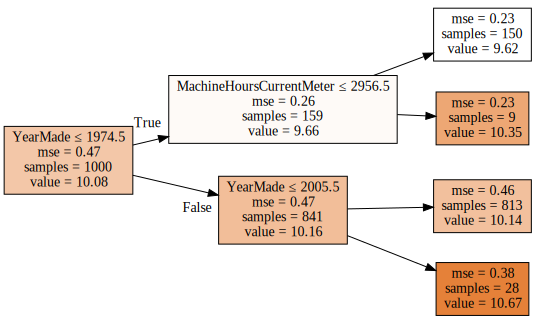

In [34]:
m=RandomForestRegressor(n_estimators=1,max_depth=2,bootstrap=False)
m.fit(x_smp,y_smp)
draw_tree(m.estimators_[0],x_smp,precision=2)

In [61]:
tree.lhs

n:159; val:9.660892662981706; score:76.82696888348357; split_value:2800.0; var:MachineHoursCurrentMeter

In [62]:
tree.rhs

n:841; val:10.158064432982941; score:571.4803525045129; split_value:2005.0; var:YearMade

In [63]:
tree.lhs.lhs

n:150; val:9.619280538108496; score:71.08938082949389; split_value:2273.0; var:MachineHoursCurrentMeter

In [64]:
tree.rhs.lhs

n:813; val:10.140438373816052; score:550.1806493212574; split_value:1994.0; var:YearMade

In [65]:
tree.rhs.rhs

n:28; val:10.669849650935848; score:15.88180285917247; split_value:3951.0; var:MachineHoursCurrentMeter

In [66]:
cols = ['MachineID', 'YearMade', 'MachineHoursCurrentMeter',
        'ProductSize', 'Enclosure','Coupler_System', 'saleYear']

In [69]:
forest=MyRandomForest(x_train[cols],y_train,1,sample_size=1000)
tree=forest.trees[0]
x_smp,y_smp=tree.x,tree.y

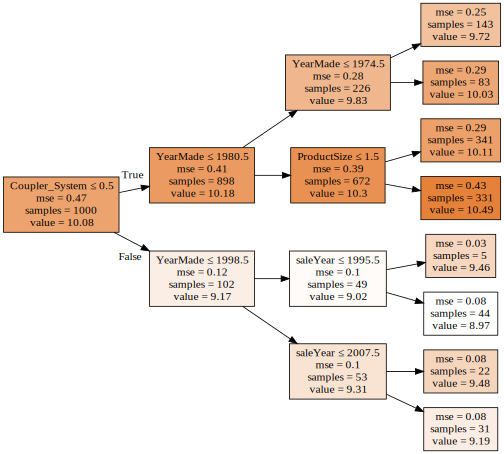

In [70]:
m=RandomForestRegressor(n_estimators=1,max_depth=3,bootstrap=False)
m.fit(x_smp,y_smp)
draw_tree(m.estimators_[0],x_smp,precision=2,ratio=0.9, size=7)